<a href="https://colab.research.google.com/github/gvaccaro2020/data_science_projects/blob/master/CNN_for_facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **MULTILAYERS KERAS CNN FOR BINARY CLASSIFICATION OF FACES (SMILING OR SERIOUS) FROM A DATASET OF 1200 IMAGES**

**Unzip Pictures from .zip file saved in  google drive and allocate them to a new folder called Pictures**

In [0]:
!unzip -uq "/content/drive/My Drive/pictures.zip" -d "/content/drive/My Drive/Pictures"

In [0]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

**Pass the name of the pictures to a dataframe**

In [0]:
filenames = os.listdir('/content/drive/My Drive/Pictures')
categories = []
for filename in filenames:
    if 'serious' in filename:
      categories.append(1)
    elif '_MACOSX' in filename:
      categories.append('MAS')
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
df = df[df.category != "MAS"]

In [0]:
df.head()

,filename,category
0,smiles_face03473.jpg,0
1,smiles_face01145.jpg,0
2,serious_face00668.jpg,1
3,smiles_face01126.jpg,0
4,serious_face00806.jpg,1


In [0]:
df['category'].describe()

count     1264
unique       2
top          1
freq       632
Name: category, dtype: int64

**Check the distribution of the two data categories in the dataframe**

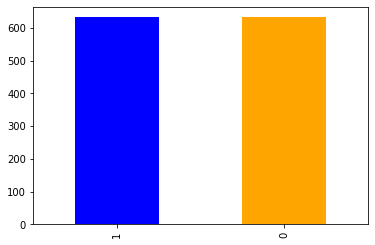

In [0]:
df['category'].value_counts().plot.bar(color=('b', 'orange'))

# **Analyze carefully the structure of the pictures to find out whether any segmentation is required**

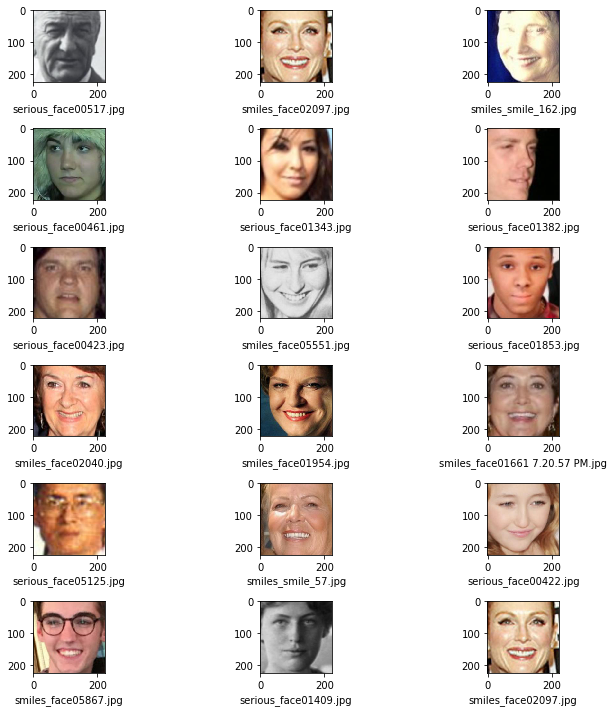

In [0]:
sample = np.random.choice(filenames,18, replace=True)
plt.figure(figsize=(10,10))
for index in range(len(sample)):
  x = sample[index]
  images= load_img("/content/drive/My Drive/Pictures/"+x)
  plt.subplot(6, 3, index+1)
  plt.imshow(images)
  plt.xlabel(x)
plt.tight_layout()
plt.show()

In [0]:
size_list = []
for img in filenames:
  if  '_MACOSX' not in img:
    folder_images = load_img("/content/drive/My Drive/Pictures/"+img)
    size_list.append(folder_images.size)

In [0]:
df_size = pd.DataFrame.from_records(size_list, columns =['Height', 'Width'])

Text(0.5, 1.0, 'Width')

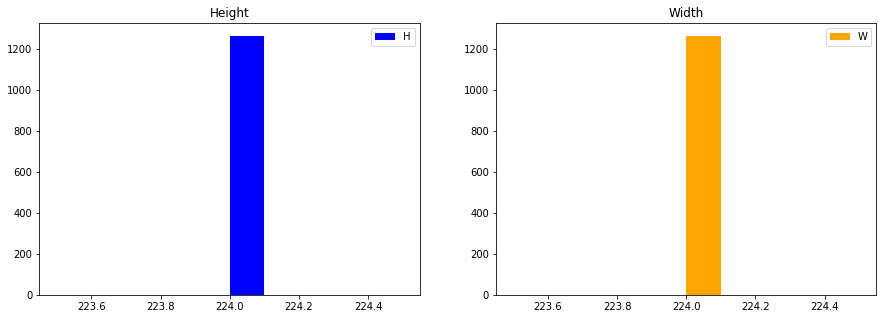

In [0]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(df_size['Height'], color='b')
plt.legend("Height")
plt.title("Height")
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(df_size['Width'], color='orange')
plt.legend('Width')
plt.title('Width')

In [0]:
print(max(size_list), min(size_list))

(224, 224) (224, 224)


**Analysis of the distribution of pixels of the three RGB dimenstions in the image dataset**

In [0]:
import skimage
from skimage import data  
from skimage.io import imread, imsave, imshow
import cv2

plt.figure(figsize=(10,10))
blue=[]
green=[]
red=[]
for x in df['filename']:
  img=cv2.imread("/content/drive/My Drive/Pictures/"+x)
  size = len(img.shape)
  B,G,R =cv2.split(img)
  blue.append(B.mean())
  green.append(G.mean())
  red.append(R.mean())
print(len(red), len(green), len(blue))

1264 1264 1264


<Figure size 720x720 with 0 Axes>

mean blue pixels: 103.0  and std is: 26.85
mean red pixels: 155.13  and std is: 27.91
mean green pixels: 118.74  and std is: 25.24


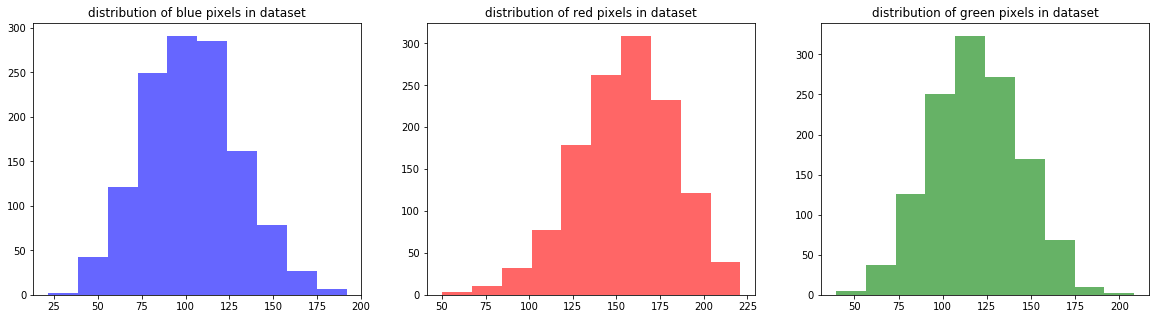

In [0]:
import statistics
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.hist(blue, color='b',alpha=0.6)
plt.title('distribution of blue pixels in dataset')

ax2 = fig.add_subplot(1, 3, 2)
ax2.hist(red, color='r',alpha=0.6)
plt.title('distribution of red pixels in dataset')

ax3 = fig.add_subplot(1, 3, 3)
ax3.hist(green, color='g',alpha=0.6)
plt.title('distribution of green pixels in dataset')

print('mean blue pixels:', round(sum(blue)/len(blue),2),' and std is:',round(statistics.stdev(blue),2))
print('mean red pixels:', round(sum(red)/len(red),2),' and std is:',round(statistics.stdev(red),2))
print('mean green pixels:', round(sum(green)/len(green),2),' and std is:',round(statistics.stdev(green),2))


Blue, Red. and Green scales are normally distributed amongst the RGB images in the dataset but there is still some  variability as we can see from std and skweness. It makes sense to normalize them to speed up the training. This will be done later using resacling in ImageDataGenarator

# **We can now start Fitting the CNN model in Keras**

In [0]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax')) # 2 because we have two classes (smiles and serious)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)     

**Define Callbacks**

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [0]:
earlystop = EarlyStopping(patience=10)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

## **Implement Train_test_split and the FIT the model**

In [0]:
df["category"] = df["category"].replace({0: 'smiles', 1: 'serious'})

In [0]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=101)
train_df, validate_df = train_test_split(train_df, test_size=0.20, random_state=101)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
total_train=train_df.shape[0]
total_validate= validate_df.shape[0]
total_test=test_df.shape[0]
print(total_train, total_validate, total_test)

808 203 253


Text(0.5, 1.0, 'test dataset')

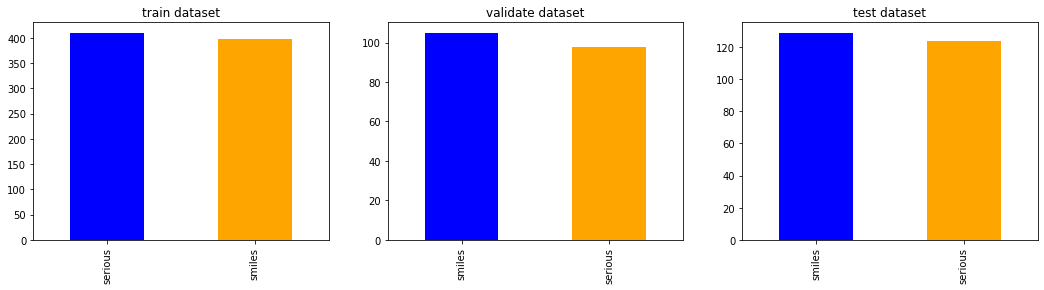

In [0]:
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1, 3, 1)

ax1 = train_df['category'].value_counts().plot.bar(color=('b','orange'))
plt.title('train dataset')

ax2 = fig.add_subplot(1, 3, 2)
ax2 = validate_df['category'].value_counts().plot.bar(color=('b','orange'))
plt.title('validate dataset')

ax3 = fig.add_subplot(1, 3, 3)
ax3 = test_df['category'].value_counts().plot.bar(color=('b','orange'))
plt.title('test dataset')


**Generate the data set of images that will be used for training, validating and testing the model using the functions ImageDataGenerator and train, validate, and test generators**

ImageDataGenerator represents a way to create Image data augmentation and involves creating transformed versions of images in the training dataset that belong to the same class as the original image
Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more
The intent is to expand the training dataset with new, plausible examples. 
This means, variations of the training set images that are likely to be seen by the model

In [0]:
batch_size=15 #define the batch size that will be using when defining the model

**1- generate the image dataset for train**

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15, # can vary from 0 to 360
    rescale=1./255, #Scaling every images to the same range [0,1] will make images contributes more evenly to the total loss.
                     # which is not the case in a normal case where some images have high pixel and some have low pixels
    shear_range=0.1, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2, #Range for random zoom
    horizontal_flip=True, #shifts the pixesl of the image in one direction
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/My Drive/Pictures/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 808 validated image filenames belonging to 2 classes.


**2- generate the image dataset for validation**

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/My Drive/Pictures/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 203 validated image filenames belonging to 2 classes.


**3- generate the image dataset for test**

In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/My Drive/Pictures/", 
    x_col='filename',
    y_col='category',
    shuffle = False,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 253 validated image filenames belonging to 2 classes.


**run sample test to check how well train_generator works**

In [0]:
sample_df = train_df.sample(n=1).reset_index(drop=True)
sample_generator = train_datagen.flow_from_dataframe(
    sample_df, 
    "/content/drive/My Drive/Pictures/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


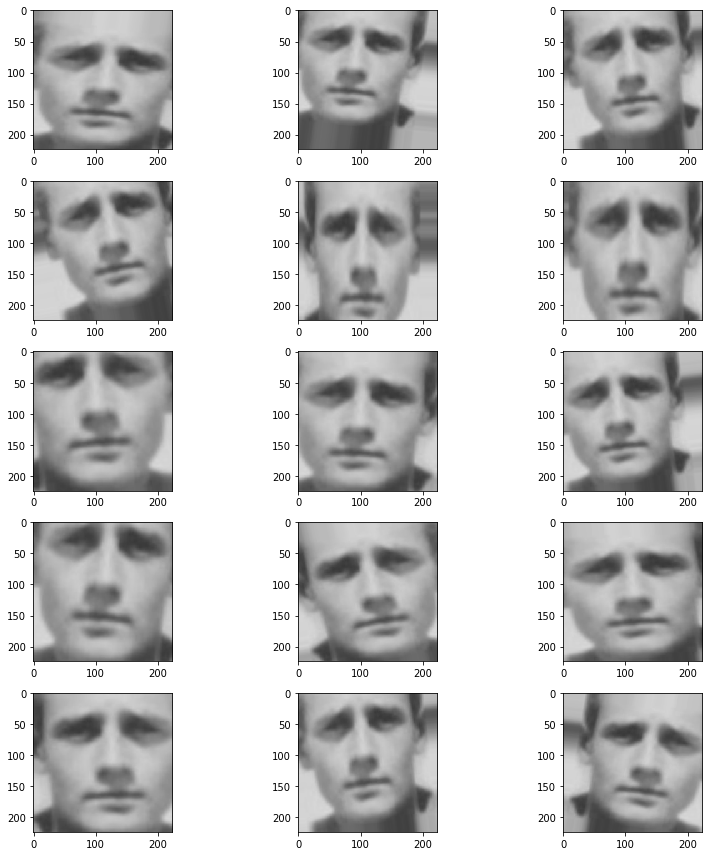

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in sample_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**FIT the model**

In [0]:
#https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 (understanding of epochs and batch_size)
epochs=50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
53/53 [==============================] - 185s 3s/step - loss: 1.6044 - acc: 0.6341 - val_loss: 0.6779 - val_acc: 0.7179
Epoch 2/50
53/53 [==============================] - 177s 3s/step - loss: 0.7148 - acc: 0.6758 - val_loss: 0.5002 - val_acc: 0.7553
Epoch 3/50
53/53 [==============================] - 180s 3s/step - loss: 0.6074 - acc: 0.7189 - val_loss: 0.5302 - val_acc: 0.7287
Epoch 4/50
53/53 [==============================] - 180s 3s/step - loss: 0.5207 - acc: 0.7651 - val_loss: 0.4963 - val_acc: 0.7606
Epoch 5/50
53/53 [==============================] - 179s 3s/step - loss: 0.5406 - acc: 0.7579 - val_loss: 0.5640 - val_acc: 0.6915
Epoch 6/50
53/53 [==============================] - 179s 3s/step - loss: 0.4892 - acc: 0.7629 - val_loss: 0.4506 - val_acc: 0.7713
Epoch 7/50
53/53 [==============================] - 180s 3s/step - loss: 0.4879 - acc: 0.7690 - val_loss: 0.4119 - val

Save the Model

In [0]:
model_json = model.to_json()

with open("/content/drive/My Drive/model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/.h5")
print("Saved model to disk")

Saved model to disk


Load the model

In [0]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/My Drive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/.h5")
print("Loaded model from disk")

Using TensorFlow backend.














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


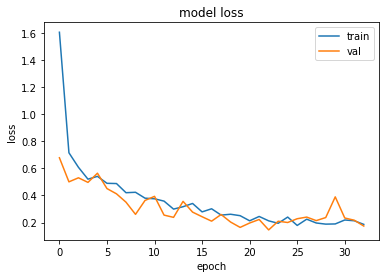

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

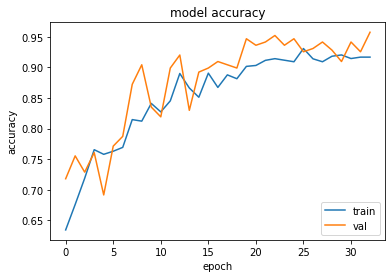

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Confusion matrix on validation

In [0]:
predict2 = model.predict_generator(validation_generator, steps=np.ceil(total_validate/batch_size))
validate_df['predicted_category'] = np.argmax(predict2, axis=-1)
label_map2 = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predicted_category'] = validate_df['predicted_category'].replace(label_map2)

In [0]:
cm1= confusion_matrix(validate_df.category, validate_df.predicted_category)
cm1

array([[48, 50],
       [48, 57]])

# **Run the test set and make predictions and use model valuation metrics**

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(total_test/batch_size))
test_df['predicted_category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predicted_category'] = test_df['predicted_category'].replace(label_map)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
test_df.head(20)

,filename,category,predicted_category
330,serious_face00044.jpg,serious,serious
457,serious_face02322.jpg,serious,serious
598,serious_face00454.jpg,serious,serious
962,serious_face00574.jpg,serious,serious
1080,smiles_face02464.jpg,smiles,smiles
45,serious_face01048.jpg,serious,serious
323,smiles_face02600.jpg,smiles,smiles
918,smiles_face03469.jpg,smiles,smiles
1021,serious_face00885.jpg,serious,serious
1194,smiles_face02811.jpg,smiles,smiles


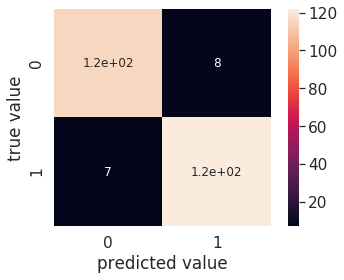

In [0]:
cm= confusion_matrix(test_df.category, test_df.predicted_category)

sns.set(font_scale=1.4)
sns.heatmap(cm, square=True, annot=True,annot_kws={"size": 12})
plt.xlabel('predicted value')
plt.ylabel('true value');

In [0]:
cm

array([[116,   8],
       [  7, 122]])

**Check parameters ROC and AUC**

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
label_map

{0: 'serious', 1: 'smiles'}

In [0]:
probs = predict[:,1]

In [0]:
fpr, tpr, thresholds  = roc_curve(test_df.category,probs, pos_label='smiles')
test_df['category_binary']=np.where(test_df['category']=='smiles',1,0)
roc_auc = roc_auc_score(test_df.category_binary, probs)
print("roc_auc:  %0.2f" % roc_auc)

roc_auc:  0.97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


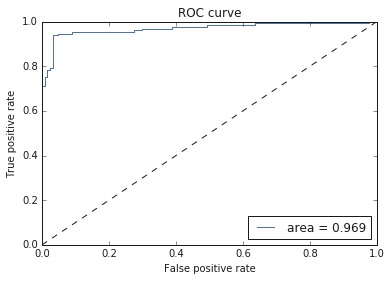

In [0]:
%matplotlib inline
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Check prediction results with images**

In [0]:
sample_predictions = np.random.choice(test_df['filename'],20)

In [0]:
df_sample_pred=test_df[test_df['filename'].isin(sample_predictions)].copy()
df_sample_pred1=df_sample_pred.reset_index()

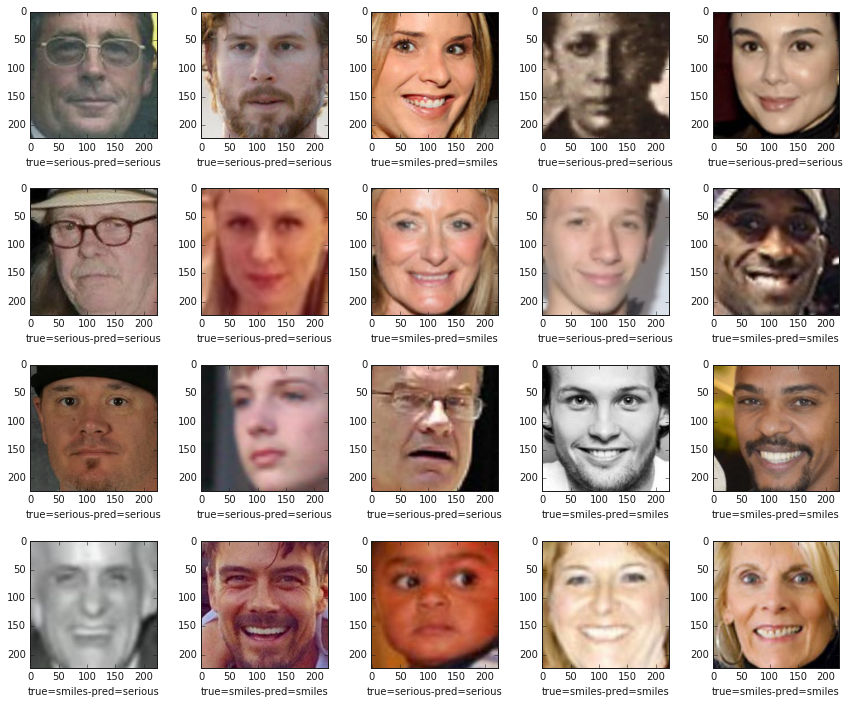

In [0]:
%matplotlib inline
plt.figure(figsize=(12,12))
for index, row in df_sample_pred1.iterrows():
    image_code = row['filename']
    true= row['category']
    category = row['predicted_category']
    images_pred = load_img("/content/drive/My Drive/Pictures/"+image_code, target_size=IMAGE_SIZE)
    plt.subplot(5, 5, index+1)
    plt.imshow(images_pred)
    plt.xlabel('true='+(true)+'-''pred='+(category))
plt.tight_layout()
plt.show()